# NLP練習：以中華民國公司法為語料
## 動機
我個人超討厭法律課~~(拖垮我GPA的罪魁禍首)~~，偏偏本系必修法律6學分，我就想：「我怎麼樣也得讓這個討人厭的東西，反過來對我有點用處吧。」於是，便選擇本學期修商事法中的《公司法》作為我的語料。

奇妙的是，若要我為了準備法律考試而讀這些法條，根本**不可能**~~(所以GPA會被拖垮其實也是因為我都裸考XDD)~~；但是當這些法條作為語料，我卻很願意花時間研讀，也順便準備期中考。

所以跟大家分享一個想題目的方向：其實也可以選一個自己討厭的主題來研究，說不定會有不同的收穫。

## 爬取條文

In [1]:
import json
import requests
from bs4 import BeautifulSoup as bs
headers = {'user-agant': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}

In [2]:
url = 'https://law.moj.gov.tw/LawClass/LawAll.aspx?pcode=J0080001'
response = requests.get(url, headers=headers)
response.encoding = 'utf-8'
html = response.text
dom = bs(html, 'html.parser')

In [3]:
labels = dom.select('div.col-no > a')
articles = dom.select('div.col-data.text-pre')

In [4]:
import jieba
import nltk
import re
import statistics as s
import pprint

In [5]:
data = []
tokens = []
deleted = 0
for i in range(0,len(labels)):
    cpn = dict(NUM=labels[i].text.strip(), Content=articles[i].text.strip().replace(' ', ''))
    text = cpn['Content']
    if text == '（刪除）':
        cpn['length'] = 0
        cpn['sub-sentences'] = 0
        cpn['sub-sent lengths'] = 'None'
        cpn['average sub-sent lengths'] = 'None'
        deleted += 1
    else:
        cpn['length'] = len(text)
        subsent = 0
        punc = [ '，', '：', '；', '。'] #用標點符號算子句數量
        for char in text:
            if char in punc:
                subsent += 1
        cpn['sub-sentences'] = subsent
        subsents = re.split(r'[，：；。]\S', text) #\S:為了不要分到最後一個句點
        subsentlen = []
        for ss in subsents:
            subsentlen.append(len(ss))
            cpn['sub-sent lengths'] = subsentlen
            cpn['average sub-sent lengths'] = s.mean(subsentlen)
        segs = jieba.lcut(text)
        for seg in segs:
            tokens.append(seg)
            types = set(tokens)
    data.append(cpn)
freqdict = nltk.FreqDist(tokens)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Yulin\AppData\Local\Temp\jieba.cache
Loading model cost 0.805 seconds.
Prefix dict has been built succesfully.


## 資料描述
公司法於去年大幅修改後，目前總共有533條條文，其中有98條被刪除。

每筆資料包含：
- NUM:條號
- Content:條文內容
- length:單條完整法條句長
- sub-sentences:單條法條所含子句數
- sub-sent lengths:各子句長度
- average sub-sent lengths:各法條中子句的平均句長

如下所示

In [19]:
print('total articles:', len(data))
print('deleted articles:', deleted)
print(data[0]) #僅頭尾的子句句長正確

total articles: 533
deleted articles: 98
{'NUM': '第 1 條', 'Content': '本法所稱公司，謂以營利為目的，依照本法組織、登記、成立之社團法人。公司經營業務，應遵守法令及商業倫理規範，得採行增進公共利益之行為，以善盡其社會責任。', 'length': 75, 'sub-sentences': 7, 'sub-sent lengths': [6, 6, 16, 5, 11, 11, 8], 'average sub-sent lengths': 9}


## 詞彙豐富度
從下面的基本統計可看出公司法的詞彙豐富度非常低，**僅0.1而已**。雖然我本來就預期不高，但沒想到竟然這麼低。不過回想了一下條文內容...嗯...還蠻合理的。主詞、受詞、行為和限制條件基本上就是幾個chunk排列組合而已。法條之所以會讓人感覺複雜，其實並不是因為內容描述的狀況大相逕庭，而是因為各種狀況高度相似而不相同，這也是讓我覺得讀法律最心累的地方。

In [12]:
print('total types:', len(types))
print('total tokens:', len(tokens))
print('type-token ratio:', len(types)/len(tokens))

total types: 3254
total tokens: 31616
type-token ratio: 0.10292257085020243


## 高頻詞符
在公司法條文的分析中，我並沒有刪除標點符號，因為標點符號的運用對條文解釋可能也是一個重要因素。
### 標點符號
首先逗號和句號極多，非常合理。

再來頓號出現823次，排第五名，表示並列的狀況很多，可能如第22-1條，在單條條文中並列：
>第一項資訊平臺之建置或指定、資料之申報期間、格式、經理人之範圍、一定條件公司之範圍、資料之蒐集、處理、利用及其費用、指定事項之內容，前項之查核程序、方式及其他應遵行事項之辦法，由中央主管機關會同法務部定之。

但也可能如第30條，是多項情形分別並列：
>有下列情事之一者，不得充經理人，其已充任者，當然解任：
一、曾犯組織犯罪防制條例規定之罪，經有罪判決確定，尚未執行、尚未執行完畢，或執行完畢、緩刑期滿或赦免後未逾五年。
二、曾犯詐欺、背信、侵占罪經宣告有期徒刑一年以上之刑確定，尚未執行、尚未執行完畢，或執行完畢、緩刑期滿或赦免後未逾二年。
三、曾犯貪污治罪條例之罪，經判決有罪確定，尚未執行、尚未執行完畢，或執行完畢、緩刑期滿或赦免後未逾二年。
四、受破產之宣告或經法院裁定開始清算程序，尚未復權。
五、使用票據經拒絕往來尚未期滿。
六、無行為能力或限制行為能力。
七、受輔助宣告尚未撤銷。

### 語詞
股東、董事、股份：公司法的主角們，戲份一定多。

其他：各種場景下會出現的布景道具(限制條件的搭配詞們)。

In [13]:
pp = pprint.PrettyPrinter(width=20, compact=True)
pp.pprint(freqdict.most_common(20))

[('，', 2323),
 ('。', 1416),
 ('之', 1365),
 ('公司', 1042),
 ('、', 823),
 ('或', 566),
 ('於', 421),
 ('董事', 355),
 ('股東', 319),
 ('為', 273),
 ('股份', 271),
 ('發行', 263),
 ('人', 240),
 ('有', 217),
 ('其', 206),
 ('時', 198),
 ('者', 193),
 ('以上', 188),
 ('得', 184),
 ('前項', 171)]


## 句長分析

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
slength = [data[i]['length'] for i in range(0, len(data)) if data[i]['length'] != 0] #不列入被刪除的法條
sscount = [data[i]['sub-sentences'] for i in range(0, len(data)) if data[i]['sub-sentences'] != 0]
avrgsslen = [data[i]['average sub-sent lengths']  for i in range(0, len(data)) if data[i]['average sub-sent lengths'] != 'None']
        
labels = [[slength,'A:單條完整法條句長'], [sscount, 'B:單條法條所含子句數'],[avrgsslen, 'C:各法條中子句的平均句長']]
for label in labels:
    print('-'*10, label[1], '-'*10)
    mu = '%.4f' % s.mean(label[0])
    var = '%.4f' % s.pvariance(label[0])
    std = '%.4f' % s.pstdev(label[0])
    mini = min(label[0])
    maxi = max(label[0])
    print('minimun = ', mini)
    print('maximum = ', maxi)
    print('mean = ', mu)
    print('variance = ', var)
    print('standard deviation = ', std)

---------- A:單條完整法條句長 ----------
minimun =  13
maximum =  860
mean =  123.6920
variance =  11048.3097
standard deviation =  105.1109
---------- B:單條法條所含子句數 ----------
minimun =  1
maximum =  57
mean =  9.1034
variance =  48.9801
standard deviation =  6.9986
---------- C:各法條中子句的平均句長 ----------
minimun =  5
maximum =  41.666666666666664
mean =  11.7810
variance =  12.9324
standard deviation =  3.5962


### 相關係數
法條越長，其所含子句數也越多，**相關係數高達0.95**。

但子句數的多寡，和各子句的句長(這邊以平均子句長來計算，否則資料數對不上)並沒有關係。

In [21]:
print('→ correlation of A and B =', '%.4f' % np.corrcoef(slength, sscount)[0][1])
print('→ correlation of B and C =', '%.4f' % np.corrcoef(avrgsslen, sscount)[0][1])

→ correlation of A and B = 0.9536
→ correlation of B and C = 0.0094


### 視覺化資料
大部分的單條法條都落在400字以內，且40-50字者最多。

而子句數量則多落在20句以內，且5句者最多。

(array([20., 33., 35., 37., 30., 34., 24., 20., 15., 18., 16., 14., 14.,
        13.,  8., 10.,  7.,  8.,  7.,  8., 11.,  8.,  4.,  4.,  3.,  4.,
         2.,  3.,  4.,  0.,  5.,  2.,  1.,  1.,  1.,  3.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.]),
 array([ 13.    ,  23.5875,  34.175 ,  44.7625,  55.35  ,  65.9375,
         76.525 ,  87.1125,  97.7   , 108.2875, 118.875 , 129.4625,
        140.05  , 150.6375, 161.225 , 171.8125, 182.4   , 192.9875,
        203.575 , 214.1625, 224.75  , 235.3375, 245.925 , 256.5125,
        267.1   , 277.6875, 288.275 , 298.8625, 309.45  , 320.0375,
        330.625 , 341.2125, 351.8   , 362.3875, 372.975 , 383.5625,
        394.15  , 404.7375, 415.325 , 425.9125, 436.5   , 447.0875,
        457.675 , 468.2625, 478.85  , 489.4375, 500.025 , 510.6125

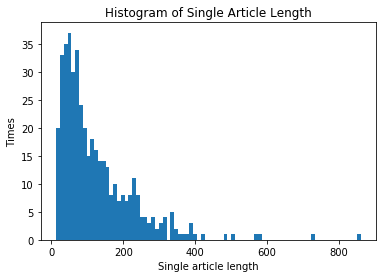

In [22]:
#單條法條句長直方圖
plt.xlabel('Single article length')
plt.ylabel('Times')
plt.title('Histogram of Single Article Length')
plt.hist(slength, bins=80)

(array([ 2., 38., 43., 46., 43., 33., 21., 26., 26., 22., 11., 19., 13.,
        13.,  0.,  6., 15.,  5., 10.,  7.,  8.,  5.,  4.,  3.,  1.,  2.,
         4.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.        ,  1.93333333,  2.86666667,  3.8       ,  4.73333333,
         5.66666667,  6.6       ,  7.53333333,  8.46666667,  9.4       ,
        10.33333333, 11.26666667, 12.2       , 13.13333333, 14.06666667,
        15.        , 15.93333333, 16.86666667, 17.8       , 18.73333333,
        19.66666667, 20.6       , 21.53333333, 22.46666667, 23.4       ,
        24.33333333, 25.26666667, 26.2       , 27.13333333, 28.06666667,
        29.        , 29.93333333, 30.86666667, 31.8       , 32.73333333,
        33.66666667, 34.6       , 35.53333333, 36.46666667, 37.4       ,
        38.33333333, 39.26666667, 40.2       , 41.13333333, 42.06666667,
 

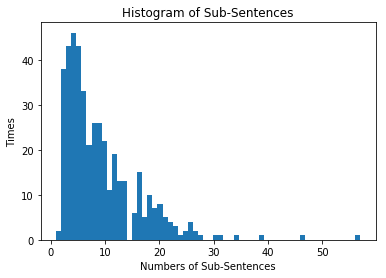

In [23]:
#子句數量直方圖
plt.xlabel('Numbers of Sub-Sentences')
plt.ylabel('Times')
plt.title('Histogram of Sub-Sentences')
plt.hist(sscount, bins = 60)

## 分析但書性質與多寡

先找出帶有「但」字的句子，根據其後之語意，大致可得兩種分類：

1. 容忍：不在此限、從其規定、不受限制、得...、免...
2. 限制：不適用之、應...、不得...、以...為限、受...限制

屬於容忍的情況共有51個，限制的情況有66個。不過仔細分析撈出來的結果後，會發現有一些問題，下面會說明。

In [24]:
T = []
L = []
for i in range(0, len(data)):
    text = data[i]['Content']
    mT = re.search(r'但.*?(不在此限?|從其.+?|不受限制?|免其.+?|免予.+?|得免.+?)。', text)  
    mL = re.search(r'但.*?(應.+?|不得.+?|不適用之|為限.*?|限制.*?)。', text) 
    if mT:
        T.append((mT.group(),data[i]['NUM']))
    if mL:
        L.append((mL.group(), data[i]['NUM']))

In [25]:
print('-'*10,'Tolerance', '-'*10)
print('-'*10,'共',len(T), '個', '-'*10)
ppp = pprint.PrettyPrinter(width=70, compact=True)
ppp.pprint(T)

---------- Tolerance ----------
---------- 共 51 個 ----------
[('但判決確定前，已為補正者，不在此限。', '第 9 條'), ('但已辦妥延展登記者，不在此限。', '第 10 條'),
 ('但自所得產生後逾一年者，不在此限。', '第 23 條'),
 ('但公司章程有較高規定者，從其規定：一、無限公司、兩合公司須有全體無限責任股東過半數同意。', '第 29 條'),
 ('但經依第二十九條第一項規定之方式同意者，不在此限。', '第 32 條'),
 ('但章程中訂定由股東中之一人或數人執行業務者，從其訂定。', '第 45 條'),
 ('但自所得產生後逾一年者，不在此限。', '第 54 條'), ('但向公司清償債務時，不在此限。', '第 59 條'),
 ('但本法或章程另有規定或經股東決議，另選清算人者，不在此限。', '第 79 條'),
 ('但清算人有不法行為時，不在此限。', '第 92 條'), ('但法定盈餘公積已達資本總額時，不在此限。', '第 112 條'),
 ('但第五款約定事項，得免予公告。', '第 133 條'),
 ('但公開發行股票之公司，證券主管機關另有規定者，不在此限。', '第 140 條'),
 ('但公開發行股票之公司，證券管理機關另有規定者，不在此限。', '第 161 條'),
 ('但因繼承者，不在此限。', '第 167-2 條'), ('但本法或其他法律另有規定者，不在此限。', '第 168 條'),
 ('但有正當事由經報請主管機關核准者，不在此限。', '第 170 條'),
 ('但公開發行股票之公司，證券主管機關另有規定者，從其規定。', '第 177 條'),
 ('但聲明撤銷前意思表示者，不在此限。', '第 177-2 條'),
 ('但股東會為前條第一項第二款之決議，同時決議解散時，不在此限。', '第 186 條'),
 ('但經表示異議之董事，有紀錄或書面聲明可證者，免其責任。', '第 193 條'),
 ('但公開發行股票之公司，證券管理機關另有規定者，不在此限。', '第 197-1 條'),
 ('但章程有較高之規定者，從其規定。', '第 204 條'),
 ('但公司章程訂定得由其他董事代理者，不在

In [26]:
print('-'*10, 'Limitation', '-'*10)
print('-'*10,'共',len(L), '個', '-'*10)
ppp.pprint(L)

---------- Limitation ----------
---------- 共 66 個 ----------
[('但政府為發展經濟、促進社會安定或其他增進公共利益等情形，對政府指派之董事所為之指揮，不適用之。', '第 8 條'),
 ('但已辦妥延展登記者，不在此限。二、開始營業後自行停止營業六個月以上。但已辦妥停業登記者，不在此限。三、公司名稱經法院判決確定不得使用，公司於判決確定後六個月內尚未辦妥名稱變更登記，並經主管機關令其限期辦理仍未辦妥。',
  '第 10 條'),
 ('但公開發行股票之公司，證券主管機關另有規定者，不適用之。', '第 20 條'),
 ('但符合一定條件之公司，不適用之。', '第 22-1 條'),
 ('但有正當理由，於期限屆滿前六個月內，報中央主管機關核准者，仍受第十八條第一項規定之限制。', '第 26-2 條'),
 ('但須指定自然人代表行使職務。政府或法人為股東時，亦得由其代表人當選為董事或監察人。代表人有數人時，得分別當選，但不得同時當選或擔任董事及監察人。',
  '第 27 條'),
 ('但公司章程有較高規定者，從其規定：一、無限公司、兩合公司須有全體無限責任股東過半數同意。二、有限公司須有全體股東表決權過半數同意。三、股份有限公司應由董事會以董事過半數之出席，及出席董事過半數同意之決議行之。',
  '第 29 條'),
 ('但其餘執行業務之股東，有一人提出異議時，應即停止執行。', '第 46 條'),
 ('但應於六個月前，以書面向公司聲明。', '第 65 條'),
 ('但非通知後不得對抗該股東：一、應出之資本不能照繳或屢催不繳者。', '第 67 條'),
 ('但將公司營業包括資產負債轉讓於他人時，應得全體股東之同意。', '第 84 條'),
 ('但法人為發起人者，以下列情形為限：一、公司或有限合夥。', '第 128 條'),
 ('但不得侵及發起人既得之利益。', '第 130 條'),
 ('但公開發行股票之公司，證券主管機關另有規定者，不在此限。採行無票面金額股之公司，其股票之發行價格不受限制。', '第 140 條'),
 ('但不得損害特別股股東按照章程應有之權利。', '第 158 條'),
 ('但公開發行股票之公司，證券主管機關另有規定者，不適用之。', 

### 遇到的問題

#### 1. 欲找出多個「不在此限」，而不是*\*只找到第一個\**。
    --以第10條為例--
    
>公司有下列情事之一者，主管機關得依職權或利害關係人之申請，命令解散之：

>一、公司設立登記後六個月尚未開始營業。***但已辦妥延展登記者，不在此限。***(→現在的regex只能找到第一個)                               

>二、開始營業後自行停止營業六個月以上。***但已辦妥停業登記者，不在此限。***(→應該也要分類到L)                                       

>三、公司名稱經法院判決確定不得使用，公司於判決確定後六個月內尚未辦妥名稱變更登記，並經主管機關令其限期辦理仍未辦妥。

>四、未於第七條第一項所定期限內，檢送經會計師查核簽證之文件者。***但於主管機關命令解散前已檢送者，不在此限。***(→應該也要分類到L)


#### 2. 重複分類到T和L
    --以第239條為例--
>法定盈餘公積及資本公積，除填補公司虧損外，不得使用之。**但第二百四十一條規定之情形，或法律另有規定者，不在此限**(→分類到T)。

>公司非於盈餘公積填補資本虧損，仍有不足時，**不得以資本公積補充之**(→又分類到L)。

但我的目標是分類到T就停止，不要後面的「不得...」。

#### 3. 錯誤的分類
    --以第306條為例--
>但公司確有重整之價值者，法院就其不同意之組，**得以下列方法之一**(→所以應該是T)，修正重整計畫裁定認可之：

>一、有擔保重整債權人之擔保財產，隨同債權移轉於重整後之公司，其權利仍存續不變。

>二、有擔保重整債權人，對於擔保之財產；無擔保重整債權人，對於可充清償其債權之財產；股東對於可充分派之賸餘財產；均得分別依公正交易價額，各按***應*得之份**，處分清償或分派承受或提存之。(→結果因為有「應」而被分配到L，但「應得之份」的語意實際上不是限制，是一種保障)

第1和第2個問題受限於我的regex使用能力>///<

第3個問題就是前後文整合語意的問題，但也是可透過更複雜的regex來挑出。

## 分析「於...」的性質與多寡
一樣先撈出所有含「於」字的句子，根據其後所接續的內容，大致可分為以下七類：
1. 於...時
2. 於...(時間)...內
3. 於...(非時間)...內
4. 於...者
5. 於...後
6. 於...前
7. 於每次/每年/每會計年度...

In [51]:
#這一段結構看起來非常笨→def可以迭代re的pattern並附加到所屬清單,再print出來的函式
AT = [] #時
IN_time = [] #時間內
IN_range = [] #非時間內
ER = [] #者
AFT = [] #後
BEF = [] #前
EVE = [] #每次/每會計年度...
for i in range(0, len(data)):
    text = data[i]['Content']
    num = data[i]['NUM']
    mAT = re.search(r'(，|；|。)(.{0,5}於.{1,20}時.+?)(。|；)', text) #201 "臨時股東會"不是"時"
    mIN_time = re.search(r'(，|；|。)(.{0,5}於.{1,20}(日|月|年|期限|任期)內.+?)(。|；)', text)
    mIN_range = re.search(r'(，|；|。)(.{0,5}於.{1,20}(範圍|境|法令)內.+?)(。|；)', text)
    mER = re.search(r'(，|；|。)(.{0,5}於.{1,20}者.+?)(。|；)', text)
    mAFT = re.search(r'(，|；|。)(.{0,5}於.{1,20}後.+?)(。|；)', text)
    mBEF = re.search(r'(，|；|。)(.{0,5}於.{1,20}前.+?)(。|；)', text) #283 
    mEVE = re.search(r'((，|；|。).{0,5}|\w.{0,20})(於每.{1,10}.+?)(，|。|；)', text) #grouping need to be adjusted 
    if mAT:
        AT.append((mAT.group(2), num))
    if mIN_time:
        IN_time.append((mIN_time.group(2), num))
    if mIN_range:
        IN_range.append((mIN_range.group(2), num))
    if mER:
        ER.append((mER.group(2), num))
    if mAFT:
        AFT.append((mAFT.group(2), num))
    if mBEF:
        BEF.append((mBEF.group(2), num))
    if mEVE:
        EVE.append((mEVE.group(3), num))

In [52]:
print('-'*10,'於...時', '-'*10)
print('-'*10,'共',len(AT), '個', '-'*10)
ppp.pprint(AT)

---------- 於...時 ----------
---------- 共 42 個 ----------
[('公司應於申請設立登記時或設立登記後三十日內，檢送經會計師查核簽證之文件', '第 7 條'),
 ('應於變更所營事業時，依代碼表規定辦理', '第 18 條'),
 ('應由股東於十五日內，向法院聲報。清算人由法院選派時，應公告之', '第 83 條'),
 ('清算人應於六個月內完結清算；不能於六個月內完結清算時，清算人得申敘理由，向法院聲請展期', '第 87 條'),
 ('得於每會計年度終了時，查閱公司帳目、業務及財產情形', '第 118 條'),
 ('發起人對於前項報告有虛偽情事時，各科新臺幣六萬元以下罰金', '第 145 條'),
 ('於股東常會開會前三十日內，股東臨時會開會前十五日內，或公司決定分派股息及紅利或其他利益之基準日前五日內，不得為之',
  '第 165 條'),
 ('但於股東清算或受破產之宣告時，得按市價收回其股份，抵償其於清算或破產宣告前結欠公司之債務', '第 167 條'),
 ('於依前項規定提請股東臨時會決議時，準用之', '第 168-1 條'), ('於必要時召集之', '第 170 條'),
 ('應於二十日前通知各股東。股東臨時會之召集，應於十日前通知各股東', '第 172 條'),
 ('應於股東會開會五日前送達公司，委託書有重複時，以最先送達者為準', '第 177 條'),
 ('並於股東會已為反對者，得請求公司以當時公平價格，收買其所有之股份', '第 186 條'),
 ('股份之移轉於價款支付時生效', '第 187 條'),
 ('於公司取銷第一百八十五條第一項所列之行為時，失其效力', '第 188 條'),
 ('公司應於股東常會開會二十五日前或股東臨時會開會十五日前，將董事候選人名單及其學歷、經歷公告', '第 192-1 條'),
 ('於就任前轉讓超過選任當時所持有之公司股份數額二分之一時，或於股東會召開前之停止股票過戶期間內，轉讓持股超過二分之一時，其當選失其效力',
  '第 197 條'),
 ('如於任期中無正當理由將其解任時，董事得向公司請求賠償因此所受之損害', '第 199 條'),
 ('董事會應於三十日內召開股東臨時會補選之', '第 201 條'

In [53]:
print('-'*10,'於..(時間)..內', '-'*10)
print('-'*10,'共',len(IN_time), '個', '-'*10)
ppp.pprint(IN_time)

---------- 於..(時間)..內 ----------
---------- 共 45 個 ----------
[('公司應於申請設立登記時或設立登記後三十日內，檢送經會計師查核簽證之文件', '第 7 條'),
 ('公司於判決確定後六個月內尚未辦妥名稱變更登記，並經主管機關令其限期辦理仍未辦妥', '第 10 條'),
 ('並於收受後十五日內，查閱發還', '第 22 條'), ('並應於變動後十五日內為之', '第 22-1 條'),
 ('於期限屆滿前六個月內，報中央主管機關核准者，仍受第十八條第一項規定之限制', '第 26-2 條'),
 ('對於登記前公司之債務，於登記後二年內，仍負連帶無限責任', '第 70 條'),
 ('或對於在指定期限內提出異議之債權人不為清償，或不提供相當擔保者，不得以其合併對抗債權人', '第 74 條'),
 ('於公司變更登記後二年內，仍負連帶無限責任', '第 78 條'), ('應由股東於十五日內，向法院聲報', '第 83 條'),
 ('清算人應於六個月內完結清算；不能於六個月內完結清算時，清算人得申敘理由，向法院聲請展期', '第 87 條'),
 ('如股東不於一個月內提出異議，即視為承認', '第 92 條'), ('至遲應於每會計年度終了後六個月內分送', '第 110 條'),
 ('於二十日內，依第一項或第二項之方式，指定受讓人', '第 111 條'),
 ('應於證券管理機關通知到達之日起三十日內，加記核准文號及年、月、日公告招募之', '第 133 條'),
 ('發起人應於二個月內召開創立會', '第 143 條'),
 ('應於設立登記或發行新股變更登記後三個月內發行股票', '第 161-1 條'),
 ('於股東常會開會前三十日內，股東臨時會開會前十五日內，或公司決定分派股息及紅利或其他利益之基準日前五日內，不得為之',
  '第 165 條'),
 ('應於六個月內，按市價將其出售，屆期未經出售者，視為公司未發行股份，並為變更登記', '第 167 條'),
 ('應於三年內轉讓於員工，屆期未轉讓者，視為公司未發行股份，並為變更登記', '第 167-1 條'),
 ('於一個月內再行召集股東會', '第 175 條'), ('並於會後二十日內，將議事錄分發各股東', 

In [54]:
print('-'*10,'於..(範圍)..內', '-'*10)
print('-'*10,'共',len(IN_range), '個', '-'*10)
ppp.pprint(IN_range)

---------- 於..(範圍)..內 ----------
---------- 共 5 個 ----------
[('於清算範圍內，視為尚未解散', '第 25 條'),
 ('於不超過該公司已發行股份總數百分之五之範圍內，收買其股份', '第 167-1 條'),
 ('於必要範圍內，檢查公司業務帳目、財產情形、特定事項、特定交易文件及紀錄', '第 245 條'),
 ('於外國公司在中華民國境內設立之分公司準用之', '第 377 條'),
 ('對於外國公司在中華民國境內營業，或分公司所生之債務，應與該外國公司負連帶責任', '第 382 條')]


In [55]:
print('-'*10,'於...者', '-'*10)
print('-'*10,'共',len(ER), '個', '-'*10)
ppp.pprint(ER)

---------- 於...者 ----------
---------- 共 32 個 ----------
[('但於主管機關命令解散前已檢送者，不在此限', '第 10 條'),
 ('依法律或基於法律授權所定之命令，須經政府許可者，於領得許可文件後，方得申請公司登記', '第 17 條'),
 ('於期限屆滿前六個月內，報中央主管機關核准者，仍受第十八條第一項規定之限制', '第 26-2 條'),
 ('不於相當期間照繳或挪用公司款項者，應加算利息，一併償還', '第 53 條'),
 ('清算人不於前項規定期限內清算完結者，各處新臺幣一萬元以上五萬元以下罰鍰', '第 87 條'),
 ('對於前項之檢查，有妨礙、拒絕或規避行為者，各處新臺幣二萬元以上十萬元以下罰鍰', '第 118 條'),
 ('非經載明於章程者，不生效力：一、分公司之設立', '第 130 條'),
 ('前項情形，於公司已印製之股票未繳回者，不適用之', '第 161-2 條'),
 ('應於六個月內，按市價將其出售，屆期未經出售者，視為公司未發行股份，並為變更登記', '第 167 條'),
 ('應於三年內轉讓於員工，屆期未轉讓者，視為公司未發行股份，並為變更登記', '第 167-1 條'),
 ('對於前二項查核有妨礙、拒絕或規避之行為者，各處新臺幣二萬元以上十萬元以下罰鍰', '第 184 條'),
 ('並於股東會已為反對者，得請求公司以當時公平價格，收買其所有之股份', '第 186 條'),
 ('其備置於股務代理機構者，公司應令股務代理機構提供', '第 210 條'),
 ('於前項準用之。以法定盈餘公積發給新股或現金者，以該項公積超過實收資本額百分之二十五之部分為限', '第 241 條'),
 ('對於檢查人之檢查有規避、妨礙或拒絕行為者，或監察人不遵法院命令召集股東會者，處新臺幣二萬元以上十萬元以下罰鍰',
  '第 245 條'),
 ('前項情形，於公司已印製之債券未繳回者，不適用之', '第 257-2 條'),
 ('而用於規定事項以外者，處公司負責人一年以下有期徒刑、拘役或科或併科新臺幣六萬元以下罰金，如公司因此受有損害時，對於公司並負賠償責任',
  '第 259 條'),
 ('於以公積抵充，核發新股予原有股東者，不適用之', '第 26

In [56]:
print('-'*10,'於...後', '-'*10)
print('-'*10,'共',len(AFT), '個', '-'*10)
ppp.pprint(AFT)

---------- 於...後 ----------
---------- 共 35 個 ----------
[('公司應於申請設立登記時或設立登記後三十日內，檢送經會計師查核簽證之文件', '第 7 條'),
 ('公司於判決確定後六個月內尚未辦妥名稱變更登記，並經主管機關令其限期辦理仍未辦妥', '第 10 條'),
 ('於領得許可文件後，方得申請公司登記', '第 17 條'), ('並於收受後十五日內，查閱發還', '第 22 條'),
 ('並應於變動後十五日內為之', '第 22-1 條'), ('於了結後計算其損益，分派其盈虧', '第 69 條'),
 ('對於登記前公司之債務，於登記後二年內，仍負連帶無限責任', '第 70 條'),
 ('於公司變更登記後二年內，仍負連帶無限責任', '第 78 條'),
 ('至遲應於每會計年度終了後六個月內分送。分送後逾一個月未提出異議者，視為承認', '第 110 條'),
 ('發起人對於公司在設立登記前所負債務，在登記後亦負連帶責任', '第 155 條'),
 ('應於設立登記或發行新股變更登記後三個月內發行股票', '第 161-1 條'),
 ('但非於公司設立登記後，不得轉讓', '第 163 條'),
 ('於股東會開會三十日前交監察人查核後，提請股東會決議', '第 168-1 條'),
 ('並於會後二十日內，將議事錄分發各股東', '第 183 條'),
 ('股東應於此期間經過後三十日內，聲請法院為價格之裁定', '第 187 條'),
 ('公司應於質權設定或解除後十五日內，將其質權變動情形，向主管機關申報並公告之', '第 197-1 條'),
 ('於股東會後三十日內，訴請法院裁判之', '第 200 條'), ('應於上屆董事任滿後十五日內召開之', '第 203 條'),
 ('提出於股東常會請求承認，經股東常會承認後，董事會應將財務報表及盈餘分派或虧損撥補之決議，分發各股東', '第 230 條'),
 ('並於發行後十五日內檢附發行相關資料，向證券主管機關報備', '第 248 條'),
 ('於證券主管機關核准通知到達後三十日內，加記核准文號及年、月、日，公告並發行之', '第 273 條'),
 ('公司應於減資登記後，定六個月以上之期限，通知各股東換取，並聲明

In [57]:
print('-'*10,'於...前', '-'*10)
print('-'*10,'共',len(BEF), '個', '-'*10)
ppp.pprint(BEF)

---------- 於...前 ----------
---------- 共 51 個 ----------
[('但於主管機關命令解散前已檢送者，不在此限', '第 10 條'),
 ('於領得許可文件後，方得申請公司登記。前項業務之許可，經目的事業主管機關撤銷或廢止確定者，應由各該目的事業主管機關，通知中央主管機關，撤銷或廢止其公司登記或部分登記事項',
  '第 17 條'),
 ('於公司登記前應先申請核准，並保留一定期間', '第 18 條'),
 ('並於收受後十五日內，查閱發還。公司負責人違反前項規定，拒絕提出時，各處新臺幣二萬元以上十萬元以下罰鍰', '第 22 條'),
 ('於期限屆滿前六個月內，報中央主管機關核准者，仍受第十八條第一項規定之限制', '第 26-2 條'),
 ('對於未加入前公司已發生之債務，亦應負責', '第 61 條'),
 ('股東得於每會計年度終了退股。但應於六個月前，以書面向公司聲明', '第 65 條'),
 ('執行法院應於二個月前通知公司及其他股東', '第 66 條'),
 ('對於登記前公司之債務，於登記後二年內，仍負連帶無限責任', '第 70 條'),
 ('於董事準用之。代表公司之董事違反前項準用第二百十一條第一項或第二項規定者，處新臺幣二萬元以上十萬元以下罰鍰', '第 108 條'),
 ('於有限公司準用之。對於依前項準用第二百四十五條第一項規定，聲請法院選派檢查人之檢查，有規避、妨礙或拒絕行為者，處新臺幣二萬元以上十萬元以下罰鍰',
  '第 110 條'),
 ('轉讓於他人。前二項轉讓，不同意之股東有優先受讓權', '第 111 條'),
 ('發起人對於公司在設立登記前所負債務，在登記後亦負連帶責任', '第 155 條'),
 ('其於轉換前依第二百四十一條第一項第一款提列之資本公積，應全數轉為資本', '第 156-1 條'),
 ('記載於公司股東名簿，不得以其轉讓對抗公司。前項股東名簿記載之變更，於股東常會開會前三十日內，股東臨時會開會前十五日內，或公司決定分派股息及紅利或其他利益之基準日前五日內，不得為之',
  '第 165 條'),
 ('抵償其於清算或破產宣告前結欠公司之債務。公司依前項但書、第一百八十六條規定，收回或收買之股份，應於六個月內，按市價將其出售，屆期未經

In [58]:
print('-'*10,'於每...', '-'*10)
print('-'*10,'共',len(EVE), '個', '-'*10)
ppp.pprint(EVE)

---------- 於每... ----------
---------- 共 8 個 ----------
[('於每會計年度終了退股。但應於六個月前', '第 65 條'), ('於每會計年度終了後六個月內分送', '第 110 條'),
 ('於每會計年度終了時，查閱公司帳目、業務及財產情形', '第 118 條'),
 ('於每會計年度終了後六個月內召開', '第 170 條'), ('於每次股東會，出具委託書，載明授權範圍', '第 177 條'),
 ('於每次出具委託書，並列舉召集事由之授權範圍', '第 205 條'),
 ('於每季或每半會計年度終了後為之', '第 228-1 條'),
 ('於每會計年度終了，造具其與控制公司間之關係報告書', '第 369-12 條')]


### 遇到的問題
#### 1.重複分類
    --以第304條為例--
>不能於一年__內__完成**時**

但因為「內」和「時」都有意義，所以分至兩類其實都是合理的。故可以再算C7取2個交集，下面將會繼續分析。
#### 2.錯誤分類
    --以第328條為例--
>對__於__足致**前**項損害賠償責任之債權(前項不是「前」)

    --以第201條為例--
>董事會應__於__三十日內召開股東臨**時**會補選之(股東臨時會不是「時」)

### 交集分析
交集結果非NONE者，表示有雙重條件，且發現最常一起出現的是「(時間)內」及「後」。

「(非時間)內」與「每」因為本來數量就少，所以和其他的組合起來取交集大都為NONE。

In [88]:
listforcom = [set(AT),set(IN_time),set(IN_range),set(ER),set(AFT),set(BEF),set(EVE)]
listforname = ['時', '(時間)內', '(非時間)內', '者', '後', '前', '每']
#取交集
for i in range(0,7):
    for j in range(1,7):
        if i+j >= 7:
            continue
        else:
            print('- ',listforname[i], '&', listforname[i+j])
            intersection = listforcom[i] & listforcom[i+j] 
            if intersection:
                print(intersection)
            else:
                print('NONE')

-  時 & (時間)內
{('對於監察人提起訴訟時，公司應自決議之日起三十日內提起之', '第 225 條'), ('不能於一年內完成時，得經重整監督人許可，聲請法院裁定延展期限', '第 304 條'), ('公司應於申請設立登記時或設立登記後三十日內，檢送經會計師查核簽證之文件', '第 7 條'), ('清算人應於六個月內完結清算；不能於六個月內完結清算時，清算人得申敘理由，向法院聲請展期', '第 87 條'), ('於股東常會開會前三十日內，股東臨時會開會前十五日內，或公司決定分派股息及紅利或其他利益之基準日前五日內，不得為之', '第 165 條'), ('董事會應於三十日內召開股東臨時會補選之', '第 201 條'), ('董事會應於三十日內召開股東臨時會選任之', '第 217-1 條')}
-  時 & (非時間)內
NONE
-  時 & 者
{('並於股東會已為反對者，得請求公司以當時公平價格，收買其所有之股份', '第 186 條')}
-  時 & 後
{('公司應於申請設立登記時或設立登記後三十日內，檢送經會計師查核簽證之文件', '第 7 條')}
-  時 & 前
{('應於股東會開會五日前送達公司，委託書有重複時，以最先送達者為準', '第 177 條'), ('於就任前轉讓超過選任當時所持有之公司股份數額二分之一時，或於股東會召開前之停止股票過戶期間內，轉讓持股超過二分之一時，其當選失其效力', '第 197 條'), ('但董事係於上屆董事任滿前改選，並決議自任期屆滿時解任者，應於上屆董事任滿後十五日內召開之', '第 203 條')}
-  時 & 每
NONE
-  (時間)內 & (非時間)內
NONE
-  (時間)內 & 者
{('應於三年內轉讓於員工，屆期未轉讓者，視為公司未發行股份，並為變更登記', '第 167-1 條'), ('應於六個月內，按市價將其出售，屆期未經出售者，視為公司未發行股份，並為變更登記', '第 167 條'), ('未能於重整裁定送達公司後一年內可決重整計畫者，法院得依聲請或依職權裁定終止重整', '第 306 條'), ('股東於前項期限內不換取者，即喪失其股東之權利，公司得將其股份拍賣，以賣得之金額，給付該股東', '第 279 條'), ('於期限屆滿前六個月內，報中央主管機關核

## TIPs learned
在過程中接觸到的新功能，雖然最後可能沒用到。
1. 快速建立由兩個清單而成的dictionary
>ALL = dict(zip(listA,listB)
2. non-greedy regex

       因為regex的修飾都在字符右手邊，若我的資料是一筆包含多個句點的文本，但只想撈到第一個句點前的內容(意即以第一個句點當作結尾)，我應該在句點前加non-greedy modifier。
3. re.group(**N**)

       N的算法：在raw string裡，由左數到右，第N個左括號，代入函式就會得到與它搭配的右括號所含的內容。

In [50]:
AT = [] #時
IN_time = [] #時間內
IN_range = [] #非時間內
ER = [] #者
AFT = [] #後
BEF = [] #前
EVE = [] #每次/每會計年度...

lis = []
mod1s = ['時', '(日|月|年|期限|任期)內', '(範圍|境|法令)內', '者', '後', '前']
for i in range(0, len(data)):
    text = data[i]['Content']
    num = data[i]['NUM']
    for mod1 in mod1s:
        string = f'(，|；|。)(.{0,5}於.{1,20}{mod1}.+?)(。|；)'
        m = re.search(string, text)
        print(m)


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
